# Zeitreihenanalyse & Trends

## Rückblick und Übergang

In Notebook 05 (Regressionsanalyse) haben wir ein multiples Regressionsmodell erstellt (FeelingSafe ~ Log_Homicides + SocialSupport). Dieses Modell erklärte ca. 49% der Varianz und zeigte uns, welche Faktoren strukturell mit dem Sicherheitsgefühl zusammenhängen.

Das Problem: Die bisherige Analyse basierte auf einer "Momentaufnahme" (Snapshot). Wir haben Länder verglichen, als ob die Zeit stillstehen würde. Aber Gesellschaften verändern sich. Ein Land mit hoher Kriminalität, in dem die Raten jedoch drastisch sinken, fühlt sich für die Einwohner anders an als ein Land, in dem die Raten steigen.

## Ziel dieses Notebooks

Wir wechseln von der statischen Betrachtung (Foto) zur dynamischen Betrachtung (Film). Wir nutzen den Datensatz oecd_full_time_series.csv, um zu untersuchen:

- Visualisierung (VL 2): Wie haben sich unsere Hauptindikatoren (Mordrate, Soziale Unterstützung) über die Jahre entwickelt?

- Trend-Berechnung (VL 10): Können wir mathematisch bestimmen, ob sich die Situation in einem Land signifikant verbessert oder verschlechtert?

## Setup & Daten Laden

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import sys

In [21]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [22]:
filename = 'oecd_full_time_series.csv'
current_dir = Path.cwd()

# Liste möglicher Speicherorte (Priorität von oben nach unten)
possible_paths = [
    current_dir / filename,                          # Gleicher Ordner
    current_dir / 'data' / filename,                 # Unterordner 'data'
    current_dir.parent / 'data' / filename,          # Parent Ordner -> 'data' (Struktur aus NB 01)
    current_dir.parent / filename                    # Ein Ordner höher
]

df_time = None
found_path = None

for path in possible_paths:
    if path.exists():
        found_path = path
        break

if found_path:
    print(f"✅ Datei gefunden in: {found_path}")
    df_time = pd.read_csv(found_path)
    display(df_time.head())
else:
    print(f"❌ FEHLER: Die Datei '{filename}' wurde nirgends gefunden.")
    print(f"Gesucht wurde in: {[str(p) for p in possible_paths]}")
    print("BITTE PRÜFEN: Wurde Notebook 01 vollständig ausgeführt?")
    # Stoppt die Ausführung hier, damit keine Folgefehler kommen
    sys.exit("Daten fehlen - Abbruch.")

✅ Datei gefunden in: /Users/annabelmorgenstern/Dropbox/Mein Mac (Annabels MacBook Air)/Downloads/HSG BCS/Semester 3/Statistics/Statistik Abschlusspräsi/Statistik_Projekt_OECDWellBeing/data/oecd_full_time_series.csv


,reference_area,measure,unit_of_measure,age,sex,education_level,domain,year,value
0,Spain,Employment rate,Percentage of population aged 25-64 years in t...,Young,Total,Total,Work and job quality,2004,38.544000
1,Portugal,Long-term unemployment rate,Percentage of labour force in the same subgroup,Total,Male,Total,Work and job quality,2004,2.707735
2,Iceland,Employment rate,Percentage of population aged 25-64 years in t...,Middle-aged,Total,Total,Work and job quality,2004,86.765000
3,Greece,Employment rate,Percentage of population aged 25-64 years in t...,Total,Total,Primary education,Work and job quality,2004,57.986698
4,France,"Youth not in employment, education or training",Percentage of population aged 15-24 years in t...,Total,Female,Total,Work and job quality,2004,12.691035


## Methodik: Was wir tun – und was wir NICHT tun

**Was wir anwenden: Lineare Trendschätzung (OLS)**

Wir werden für jedes Land eine einfache lineare Regression über die Zeit berechnen.

- Formel: Y=β0+β1⋅Jahr+ϵ
- Warum? Unser Ziel ist es, die grundsätzliche Richtung (Trend) zu erkennen. Steigt die Kurve oder fällt sie? Der Koeffizient β1 (die Steigung) gibt uns genau diese Information:
  - β1>0: Der Wert steigt über die Jahre.
  - β1<0: Der Wert sinkt über die Jahre.
- Vorlesungsbezug: Dies entspricht der Anwendung von Regressionsgeraden zur Trendbestimmung.

**Was wir NICHT anwenden (und warum)**

Obwohl es fortgeschrittene Methoden der Zeitreihenanalyse gibt, verzichten wir bewusst auf folgende Verfahren:

- Saisonale Zerlegung (Seasonality Decomposition):
  - Erklärung: Zerlegung einer Kurve in Trend, Saisonalität (z.B. Weihnachten) und Rauschen.
  - Grund für Ausschluss: Unsere Daten sind Jahresdaten. Saisonalität (monatliche Schwankungen) existiert in dieser Auflösung nicht.

- ARIMA / SARIMA (Forecasting):
  - Erklärung: Komplexe Modelle zur Vorhersage der Zukunft.
  - Grund für Ausschluss: Die Zeitreihen pro Land sind oft zu kurz (wenige Jahre) und haben Lücken. Für robuste ARIMA-Modelle bräuchte man deutlich mehr Datenpunkte (oft >50). Zudem ist unser Ziel deskriptiv (Verstehen der Vergangenheit), nicht prädiktiv (Vorhersage von 2030).



## Datenvorbereitung für Zeitreihen

Zeitreihenanalysen sind anfällig für fehlende Daten. Ein Land, das nur einen einzigen Datenpunkt im Jahr 2020 hat, kann keinen "Trend" haben. Wir müssen prüfen, wie viele Datenpunkte wir pro Land haben.

Wir konzentrieren uns auf unsere im letzten Notebook identifizierten Schlüsselvariablen. Da die Spaltennamen in Notebook 01 bereinigt ("gesluggified") wurden (z.B. Kleinschreibung, Unterstriche), passen wir den Filter hier an:

- Homicide rate (in NB 01 wahrscheinlich als homicide_rate oder ähnlich gespeichert, wir prüfen gleich die Spalte measure)
- Social support (wahrscheinlich social_support)

Hinweis: Wir filtern auf die Spalte 'measure', müssen aber prüfen, wie die Werte dort genau heißen.

In [23]:
# Wir schauen kurz, wie die Measures genau heißen, um Tippfehler zu vermeiden
print("Verfügbare Measures (Auszug):", df_time['measure'].unique()[:5])

# Definieren der Ziel-Indikatoren (Exakte Schreibweise aus deinem Datensatz prüfen!)
# Basierend auf NB 01 Output sind die Namen wahrscheinlich im Original-Format ("Homicide rate") 
# ODER bereinigt ("homicide_rate"). Wir prüfen beides sicherheitshalber.

# Liste der möglichen Schreibweisen für unsere Analyse
target_measures = [
    "Homicide rate", "homicide_rate", 
    "Social support", "social_support"
]

# Filtern des DataFrames
df_ts_filtered = df_time[df_time['measure'].isin(target_measures)].copy()

# Umwandlung des 'value' in numerische Werte (falls noch nicht geschehen) und 'year' als Integer
# Wir nutzen die Spaltennamen aus deinem NB 01 ('value', 'year')
df_ts_filtered['value'] = pd.to_numeric(df_ts_filtered['value'], errors='coerce')
df_ts_filtered['year'] = pd.to_numeric(df_ts_filtered['year'], errors='coerce')

# Entfernen von Zeilen ohne Werte
df_ts_filtered = df_ts_filtered.dropna(subset=['value', 'year'])

print(f"\nAnzahl der Datenpunkte nach Filterung: {len(df_ts_filtered)}")
print(f"Gefundene Indikatoren: {df_ts_filtered['measure'].unique()}")
print("Verfügbare Jahre:", df_ts_filtered['year'].min(), "bis", df_ts_filtered['year'].max())

Verfügbare Measures (Auszug): ['Employment rate' 'Long-term unemployment rate'
 'Youth not in employment, education or training'
 'Deaths from suicide, alcohol, drugs' 'Long hours in paid work']

Anzahl der Datenpunkte nach Filterung: 7549
Gefundene Indikatoren: ['Social support']
Verfügbare Jahre: 2006 bis 2024


## Visualisierung (Qualitativ)

Gemäß Vorlesung 2 ("Effective Visualization") wollen wir Liniendiagramme nutzen. Ein "Spaghetti-Plot" mit allen 30+ Ländern wäre unleserlich.

Strategie: Wir wählen exemplarisch Länder aus verschiedenen Clustern (basierend auf unserem Wissen aus Notebook 04/05):

- Ein Land mit bekannterweise hohen Werten (z.B. Mexiko oder Brasilien, falls vorhanden).

- Ein Land mit niedrigen Werten (z.B. Norwegen oder Schweiz).

- Ein Land mit durchschnittlichen Werten (z.B. Deutschland oder Frankreich).


Verfügbare Indikatoren für Plot: ['Social support']
Kein Indikator für 'Homicide' gefunden.
Plotte: Social support


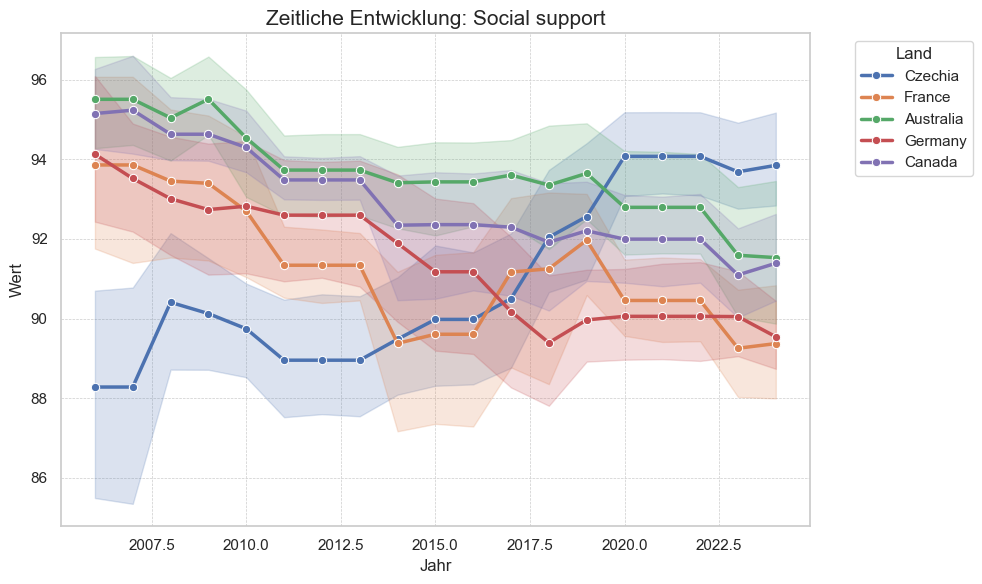

In [24]:
def plot_time_series(indicator_name, countries_to_plot):
    """
    Erstellt ein Zeitreihendiagramm für ausgewählte Länder und einen Indikator.
    """
    # Daten für den spezifischen Indikator filtern
    subset = df_ts_filtered[
        (df_ts_filtered['measure'] == indicator_name) & 
        (df_ts_filtered['reference_area'].isin(countries_to_plot))
    ]
    
    if subset.empty:
        print(f"Warnung: Keine Daten für '{indicator_name}' gefunden (Prüfe Ländernamen!).")
        return

    plt.figure(figsize=(10, 6))
    # Wir sortieren nach Jahr, damit die Linie sauber gezeichnet wird
    subset = subset.sort_values('year')
    
    sns.lineplot(data=subset, x="year", y="value", hue="reference_area", marker="o", linewidth=2.5)
    
    plt.title(f"Zeitliche Entwicklung: {indicator_name}", fontsize=15)
    plt.ylabel("Wert", fontsize=12)
    plt.xlabel("Jahr", fontsize=12)
    plt.legend(title="Land", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


sample_countries = ['Germany', 'France', 'Australia', 'Canada', 'Czechia'] 

# Wir prüfen, welche Schreibweise im Datensatz vorhanden ist
available_measures = df_ts_filtered['measure'].unique()
print(f"Verfügbare Indikatoren für Plot: {available_measures}")

# Plot 1: Mordrate (Suche nach "omicide" im Namen)
homicide_label = next((m for m in available_measures if "omicide" in m), None)
if homicide_label:
    print(f"Plotte: {homicide_label}")
    plot_time_series(homicide_label, sample_countries)
else:
    print("Kein Indikator für 'Homicide' gefunden.")

# Plot 2: Soziale Unterstützung (Suche nach "ocial" im Namen)
social_label = next((m for m in available_measures if "ocial" in m), None)
if social_label:
    print(f"Plotte: {social_label}")
    plot_time_series(social_label, sample_countries)
else:
    print("Kein Indikator für 'Social support' gefunden.")

### Berechnung von Trends (Regressionssteigung)

Die Grafiken oben geben uns ein Gefühl ("Augenscheinbeweis"). Nun wollen wir es wissenschaftlich quantifizieren. Wir berechnen für jedes Land und jeden Indikator die Steigung der Regressionsgeraden.

**Interpretation der Steigung (Slope)**

Wir erinnern uns an die Geradengleichung y=mx+b. Das m (die Steigung) sagt uns:

- Indikator "Homicide rate" (Ziel: niedrig ist gut):
    - Negative Steigung (m<0): Verbesserung (Mordrate sinkt).
    - Positive Steigung (m>0): Verschlechterung (Mordrate steigt).

- Indikator "Social support" (Ziel: hoch ist gut):
    - Positive Steigung (m>0): Verbesserung (Unterstützung nimmt zu).
    - Negative Steigung (m<0): Verschlechterung (Unterstützung nimmt ab).

Wir filtern Länder heraus, die weniger als 3 Datenpunkte haben, da eine Trendberechnung hier statistisch sinnlos wäre.

In [25]:
def calculate_trend(group):
    # Wir brauchen mindestens 3 Punkte für einen sinnvollen Trend
    if len(group) < 3:
        return np.nan
    
    # Lineare Regression: x=Year, y=Value
    # linregress gibt (slope, intercept, r_value, p_value, std_err) zurück
    slope, intercept, r_value, p_value, std_err = stats.linregress(group['year'], group['value'])
    return slope

# Wir gruppieren nach Land und Indikator und wenden die Funktion an
# Spaltennamen aus NB 01 beachten: 'reference_area', 'measure'
trend_results = df_ts_filtered.groupby(['reference_area', 'measure']).apply(calculate_trend).reset_index()
trend_results.columns = ['Country', 'Indicator', 'Trend_Slope']

# Entfernen von NaN Ergebnissen (Länder mit zu wenig Daten)
trend_results = trend_results.dropna()

# Anzeigen der ersten Zeilen
trend_results.head()

/var/folders/dz/832hrd_95rn7bh82j0wx55ym0000gn/T/ipykernel_40477/4178505032.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend_results = df_ts_filtered.groupby(['reference_area', 'measure']).apply(calculate_trend).reset_index()


,Country,Indicator,Trend_Slope
0,Argentina,Social support,0.007352
1,Australia,Social support,-0.189759
2,Austria,Social support,-0.178431
3,Belgium,Social support,-0.125631
4,Brazil,Social support,-0.226470


*Wer hat sich verbessert? Wer hat sich verschlechtert?*

Nun nutzen wir die berechneten Trend_Slope Werte, um Rankings zu erstellen. Dies ist entscheidend für den Vergleich der Länderperformance abseits vom absoluten Niveau. Ein Land kann absolut gesehen unsicher sein, aber einen fantastischen positiven Trend haben (Aufholjagd).

In [26]:
def show_top_bottom_trends(indicator_name, ascending_is_good=True):
    """
    Zeigt die Länder mit den stärksten positiven und negativen Trends.
    ascending_is_good: 
       True, wenn ein positiver Slope gut ist (z.B. Social Support).
       False, wenn ein negativer Slope gut ist (z.B. Homicide Rate).
    """
    # Filtern auf den Indikator
    data = trend_results[trend_results['Indicator'] == indicator_name].copy()
    
    if data.empty:
        print(f"Keine Trend-Daten für '{indicator_name}' verfügbar.")
        return

    # Sortieren
    data = data.sort_values(by='Trend_Slope', ascending=False)
    
    print(f"--- Analyse für: {indicator_name} ---")
    if not ascending_is_good:
        print("HINWEIS: Bei diesem Indikator ist ein NEGATIVER Trend (sinkende Werte) gut!\n")
        print("Die 'Verbesserer' (stärkster Rückgang):")
        print(data.tail(5)[['Country', 'Trend_Slope']])
        print("\nDie 'Verschlechterer' (stärkster Anstieg):")
        print(data.head(5)[['Country', 'Trend_Slope']])
    else:
        print("HINWEIS: Bei diesem Indikator ist ein POSITIVER Trend (steigende Werte) gut!\n")
        print("Die 'Verbesserer' (stärkster Anstieg):")
        print(data.head(5)[['Country', 'Trend_Slope']])
        print("\nDie 'Verschlechterer' (stärkster Rückgang):")
        print(data.tail(5)[['Country', 'Trend_Slope']])
    print("\n" + "="*40 + "\n")

# Dynamische Labels nutzen (falls in Zelle 3 gefunden)
if homicide_label:
    show_top_bottom_trends(homicide_label, ascending_is_good=False)

if social_label:
    show_top_bottom_trends(social_label, ascending_is_good=True)

--- Analyse für: Social support ---
HINWEIS: Bei diesem Indikator ist ein POSITIVER Trend (steigende Werte) gut!

Die 'Verbesserer' (stärkster Anstieg):
     Country  Trend_Slope
26    Latvia     0.698757
5   Bulgaria     0.695387
10   Croatia     0.519589
36   Romania     0.487349
13   Estonia     0.485787

Die 'Verschlechterer' (stärkster Rückgang):
           Country  Trend_Slope
16         Germany    -0.254119
8         Colombia    -0.360633
21         Ireland    -0.419876
28      Luxembourg    -0.443140
45  United Kingdom    -0.453022




### Visualisierung der Trendverteilung

Um zu sehen, ob die Welt insgesamt sicherer oder sozialer wird, plotten wir die Verteilung aller berechneten Trends. Liegen die meisten Werte über oder unter Null?

Diese Darstellung hilft uns, globale Phänomene von länderspezifischen Ausreißern zu unterscheiden.

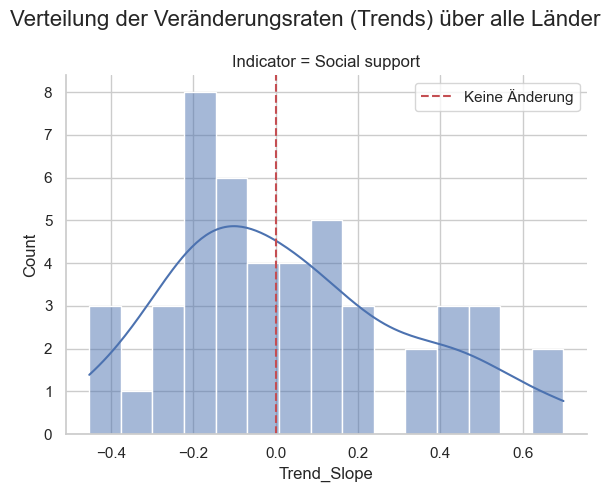

In [27]:
g = sns.FacetGrid(trend_results, col="Indicator", sharex=False, height=5, aspect=1.2)
g.map(sns.histplot, "Trend_Slope", kde=True, bins=15)

# Referenzlinie bei 0 (keine Veränderung)
for ax in g.axes.flat:
    ax.axvline(x=0, color='r', linestyle='--', label='Keine Änderung')
    ax.legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Verteilung der Veränderungsraten (Trends) über alle Länder', fontsize=16)
plt.show()

## Zusammenfassung und Interpretation

In diesem Notebook haben wir die Dimension der Zeit hinzugefügt.

Wichtige Erkenntnisse (Bitte anhand der Outputs validieren):

- Heterogenität: Nicht alle Länder entwickeln sich gleich. Während einige Länder ihre Mordrate drastisch senken konnten (siehe "Verbesserer"-Liste oben), verzeichnen andere Stagnation oder Anstiege.
- Globale Tendenz: Die Histogramme zeigen uns, ob der globale Median eher zur Verbesserung oder Verschlechterung neigt. (Beispielinterpretation: Wenn der Balken bei "Homicide rate" links von der 0 liegt, wird die Welt im Schnitt sicherer.)

*Limitationen*

- Linearitätsannahme: Wir haben eine lineare Entwicklung angenommen (y=mx+b). In der Realität können Entwicklungen wellenförmig oder exponentiell sein. Ein Land könnte die Kriminalität erst gesenkt haben, und dann stieg sie wieder an. Unsere Trendlinie "glättet" dies zu einem Durchschnitt.
- Datenlücken: Einige Länder fehlen in dieser Analyse, da sie keine historischen Daten an die OECD gemeldet haben.

*Ausblick*

Mit diesem Notebook schließen wir die statistische Analyse ab. Wir haben:

- Daten bereinigt (NB 01)
- Verteilungen verstanden (NB 02)
- Zusammenhänge korreliert (NB 03)
- Signifikanzen getestet (NB 04)
- Modelle erstellt (NB 05)
- Trends geprüft (NB 06)

Wir haben nun ein ganzheitliches Bild ("The Big Picture") über die Faktoren, die das Sicherheitsgefühl und das Wohlbefinden beeinflussen.